# Seminar 2. Training networks in PyTorch

On this seminar, we will train Lenet-5 on a MNIST dataset using PyTorch.

For the beginning, you can read several examples of training CNNs in PyTorch:
* [Example 1](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py)
* [Example 2](https://github.com/jcjohnson/pytorch-examples/blob/master/nn/two_layer_net_nn.py)

### Data loading in pytorch

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.utils.data

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
RANDOM_SEED = 0
LEARNING_RATE = 0.001
BATCH_SIZE = 64
N_EPOCHS = 20
IMG_SIZE = 28
N_CLASSES = 10
N_CHANNELS = 1

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

You will works with a MNIST dataset. It contains grayscale images of handwritten digits of size 28 x 28. The number of training objects is 60000. 


In pytorch, there is a special module to download MNIST. But for us it is more convinient to load the data ourselves.

In [3]:
from util import load_mnist

In [4]:
X_train, y_train, X_test, y_test = load_mnist()

The code below prepares short data (train and val) for seminar purposes (use this data to quickly learn model on CPU and to tune the hyperparameters). Also, we prepare the full data (train_full and test) to train a final model.

In [5]:
# shuffle data
idxs = np.random.permutation(np.arange(X_train.shape[0]))
X_train, y_train = X_train[idxs], y_train[idxs]
                            
X_train.shape

(60000, 1, 28, 28)

Pytorch offers convinient class DataLoader for mini batch generation. You should pass instance of Tensor Dataset to it.

In [6]:
def get_loader(X, y, batch_size=BATCH_SIZE):
    train = torch.utils.data.TensorDataset(torch.from_numpy(X).float(), 
                                       torch.from_numpy(y).long())
    train_loader = torch.utils.data.DataLoader(train, 
                                               batch_size=batch_size)
    return train_loader

# for final model:
train_loader_full = get_loader(X_train, y_train) 
test_loader = get_loader(X_test, y_test)

# for validation purposes:
train_loader = get_loader(X_train[:15000], y_train[:15000])
val_loader = get_loader(X_train[15000:30000], y_train[15000:30000])

/tmp/ipykernel_59910/126736942.py:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  torch.from_numpy(y).long())


In [7]:
# check number of objects
val_loader.dataset.tensors[0].shape

torch.Size([15000, 1, 28, 28])

### Building LeNet-5

Convolutional layer (from Anton Osokin's presentation):
![slide](https://github.com/nadiinchi/dl_labs/raw/master/convolution.png)

You need to implement Lenet-5:

![Архитектура LeNet-5](https://www.researchgate.net/profile/Vladimir_Golovko3/publication/313808170/figure/fig3/AS:552880910618630@1508828489678/Architecture-of-LeNet-5.png)

Construct a network according to the image and code examples given above. Use ReLU nonlinearity (after all linear and convolutional layers). The network must support multiplying the number of convolutions in each convolutional layer by k.

Please note that on the scheme the size of the image is 32 x 32 but in our code the size is 28 x 28.

Do not apply softmax at the end of the forward pass!

In [8]:
class CNN(nn.Module):
    def __init__(self, n_channels=N_CHANNELS, n_classes=N_CLASSES, k=1):
        super(CNN, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=n_channels, out_channels=6, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1080, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Let's count the number of the parameters in the network:

In [9]:
cnn = CNN()

In [10]:
def count_parameters(model):
    return sum(param.data.numpy().size for param \
               in model.parameters() if param.requires_grad)

count_parameters(cnn)

109994

### Training

Let's define the loss function:

In [11]:
Criterion = nn.CrossEntropyLoss() # loss includes softmax

Also, define a device where to store the data and the model (cpu or gpu):

In [12]:
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {Device}")

cnn = cnn.to(Device)

Device is cpu


During training, we will control the quality on the training and validation set. This produces duplicates of the code. That's why we will define a function evaluate_loss_acc to evaluate our model on different data sets. In the same manner, we define function train_epoch to perform one training epoch on traiing data. Please note that we will compute the training loss _after_ each epoch (not averaging it during epoch).

In the propotypes, train and eval modes are noted. In our case, we don't need them (because we don't use neither dropout nor batch normalization). However, we will switch the regime so you can use this code in the future.

In [13]:
def train_epoch(model, train_loader, optimizer, criterion=Criterion, device=Device):
    """
    for each batch 
    performs forward and backward pass and parameters update 
    
    Input:
    model: instance of model (example defined above)
    train_loader: instance of DataLoader (defined above)
    optimizer: instance of optimizer
    criterion: loss function (defined above)
    
    Returns:
    nothing
    
    Do not forget to set net to train mode!
    """
    
    model.train()
    
    for X, y_true in train_loader:
        optimizer.zero_grad()
        
        X, y_true = X.to(device), y_true.to(device)
    
        # Forward pass
        y_pred = model(X) 
        loss = criterion(y_pred, y_true) 

        # Backward pass
        loss.backward()
        optimizer.step()

def evaluate_loss_acc(model, test_loader, criterion=Criterion, device=Device):
    """
    Evaluates loss and accuracy on the whole dataset
    
    Input:
    model: instance of model (examle defined above)
    loader:  instance of DataLoader (examle defined above)
    criterion: loss function (defined above)
    
    Returns:
    (loss, accuracy)
    
    Do not forget to set net to eval mode!
    """
    
    model.eval()
    running_loss = 0
    n_pred_true = 0
    
    for X, y_true in test_loader:
        X, y_true = X.to(device), y_true.to(device)

        # Forward pass and record loss and accuracy
        y_pred = model(X) 
        loss = criterion(y_pred, y_true) 
        running_loss += loss.item() * X.size(0)
        
        for i in range(y_pred.shape[0]):
            if np.argmax(y_pred[i].detach()) == y_true[i].item():
                n_pred_true += 1

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = n_pred_true / len(test_loader.dataset)
        
    return epoch_loss, epoch_acc
    
def train(model, opt, train_loader, test_loader, criterion=Criterion, n_epochs=N_EPOCHS, \
          device=Device, verbose=True):
    """
    Performs training of the model and prints progress
    
    Input:
    model: instance of model (example defined above)
    opt: instance of optimizer 
    train_loader: instance of DataLoader
    test_loader: instance of DataLoader (for evaluation)
    n_epochs: int
    
    Returns:
    4 lists: train_log, train_acc_log, val_log, val_acc_log
    with corresponding metrics per epoch
    """
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        train_epoch(model, train_loader, opt, criterion, device)
        train_loss, train_acc = evaluate_loss_acc(model, 
                                                  train_loader, 
                                                  criterion, 
                                                  device)
        val_loss, val_acc = evaluate_loss_acc(model, 
                                              test_loader,
                                              criterion, 
                                              device)

        train_log.append(train_loss)
        train_acc_log.append(train_acc)

        val_log.append(val_loss)
        val_acc_log.append(val_acc)
        
        if verbose:
             print (('Epoch [%d/%d], Loss (train/test): %.4f/%.4f,'+\
               ' Acc (train/test): %.4f/%.4f' )
                   %(epoch+1, n_epochs, \
                     train_loss, val_loss, train_acc, val_acc))
            
    return train_log, train_acc_log, val_log, val_acc_log

Train the neural network, using defined functions. Use Adam as an optimizer, learning_rate=0.001, number of epochs = 20. For hold out, use val_loader, not test_loader.

In [14]:
### your code here
Optimizer = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

train_log, train_acc_log, val_log, val_acc_log = train(cnn, 
                                                      Optimizer,
                                                      train_loader,
                                                      val_loader)

Epoch [1/20], Loss (train/test): 0.3489/0.3638, Acc (train/test): 0.8983/0.8914
Epoch [2/20], Loss (train/test): 0.2081/0.2306, Acc (train/test): 0.9367/0.9287
Epoch [3/20], Loss (train/test): 0.1526/0.1828, Acc (train/test): 0.9523/0.9437
Epoch [4/20], Loss (train/test): 0.1167/0.1522, Acc (train/test): 0.9635/0.9531
Epoch [5/20], Loss (train/test): 0.0893/0.1297, Acc (train/test): 0.9716/0.9601
Epoch [6/20], Loss (train/test): 0.0677/0.1121, Acc (train/test): 0.9786/0.9650
Epoch [7/20], Loss (train/test): 0.0542/0.1027, Acc (train/test): 0.9839/0.9689
Epoch [8/20], Loss (train/test): 0.0468/0.0998, Acc (train/test): 0.9853/0.9695
Epoch [9/20], Loss (train/test): 0.0451/0.1051, Acc (train/test): 0.9853/0.9691
Epoch [10/20], Loss (train/test): 0.0435/0.1114, Acc (train/test): 0.9856/0.9693
Epoch [11/20], Loss (train/test): 0.0435/0.1191, Acc (train/test): 0.9853/0.9687
Epoch [12/20], Loss (train/test): 0.0399/0.1196, Acc (train/test): 0.9872/0.9696
Epoch [13/20], Loss (train/test): 0.0

Let's visualize the activations of the network when images pass through it. The code below draws a table of images: the first column shows original images, the following 6 columns show images when the filters are applied to them. To use this code, save batch containing 10 images to x and the output of the first convolutional layer (before ReLU) on these images to y.

In [28]:
for X, y_true in test_loader:
    x = X[:10]
    X = X.to(Device)

    y = cnn.feature_extractor[:1](X)[:10]
    
    break

In [29]:
def plot(x, y):
    plt.figure(figsize=(15, 15))
    for im in range(10):
        plt.subplot(11, 7, im*7+1)
        plt.imshow(x.data[im, 0])
        plt.axis("off")
        for i in range(6):
            plt.subplot(11, 7, im*7+i+2)
            plt.imshow(y.data[im, i].numpy())
            plt.axis("off")

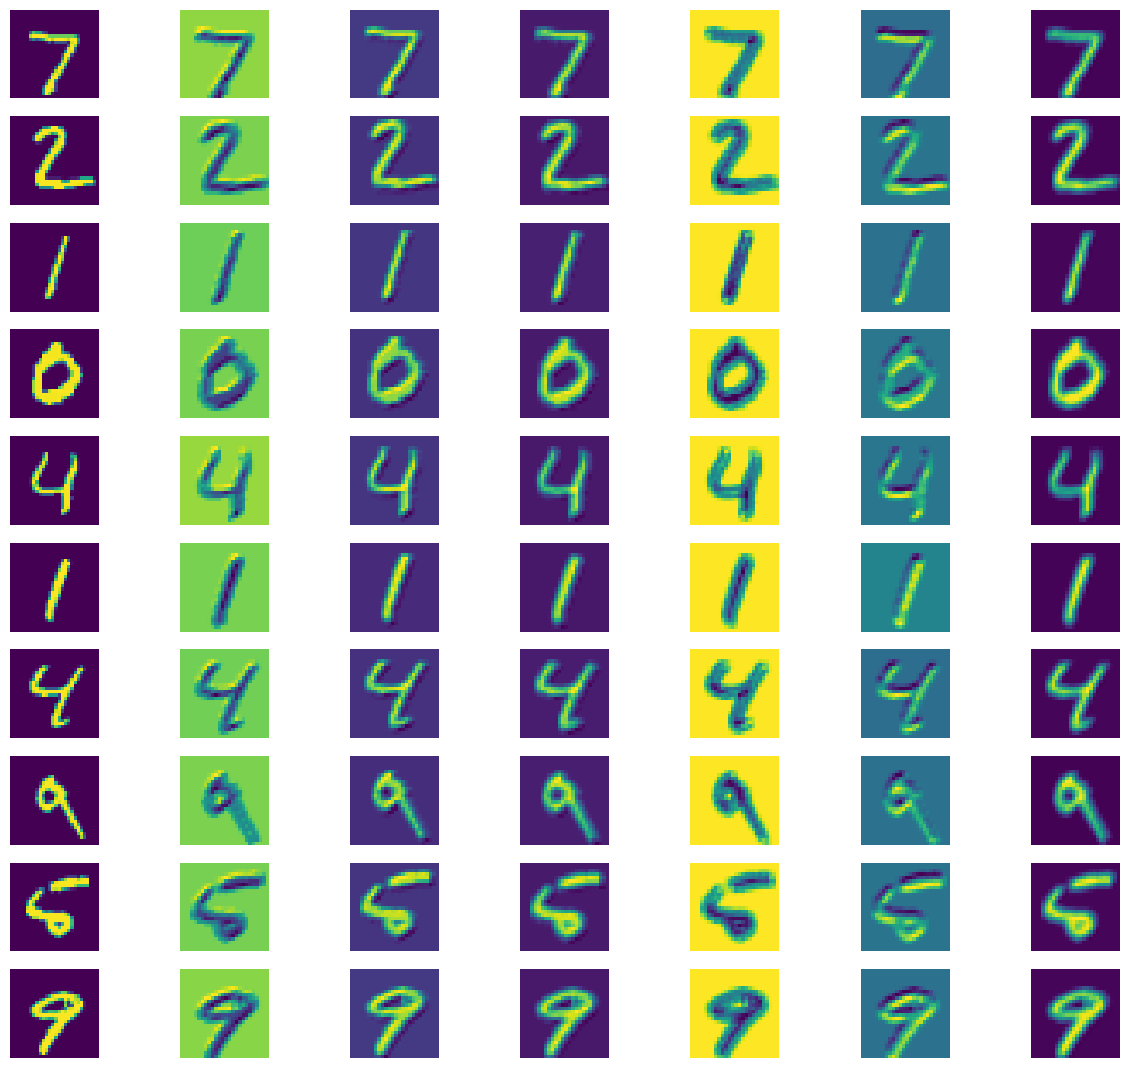

In [30]:
plot(x, y)

Now visualize the result of applying the second convolutional layer (before ReLU) to images:

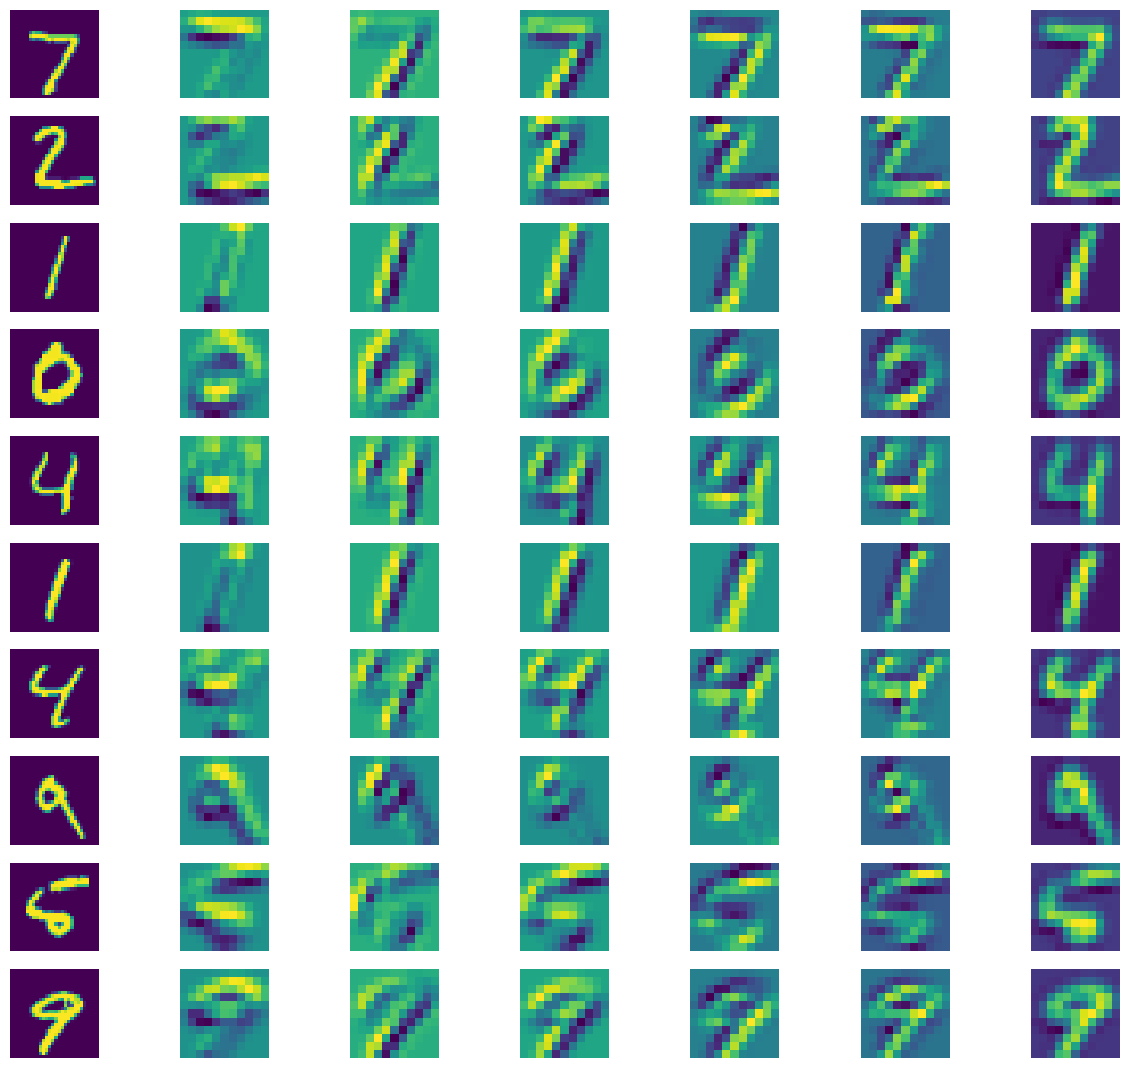

In [31]:
for X, y_true in test_loader:
    x = X[:10]
    X = X.to(Device)

    y = cnn.feature_extractor[:4](X)[:10]
    
    break
    
plot(x, y)


### Choosing  learning_rate and batch_size

Plot accuracy on the training and testing set v. s. training epoch for different learning parameters: learning rate$ \in \{0.0001, 0.001, 0.01\}$, batch size $\in \{64, 256\}$. 

The best option is to plot training curves on the left graph and validation curves on the right graph with the shared y axis (use plt.ylim).

How do learning rate and batch size affect the final quality of the model?

In [35]:
cnn = CNN().to(Device)

train_loader = get_loader(X_train[:15000], y_train[:15000], 64)
val_loader = get_loader(X_train[15000:30000], y_train[15000:30000], 64)

Optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0001)

train_log_1, train_acc_log_1, val_log_1, val_acc_log_1 = train(cnn,
                                                      Optimizer,
                                                      train_loader,
                                                      val_loader)

Epoch [1/20], Loss (train/test): 1.4828/1.4838, Acc (train/test): 0.6704/0.6657
Epoch [2/20], Loss (train/test): 0.6104/0.6149, Acc (train/test): 0.8288/0.8275
Epoch [3/20], Loss (train/test): 0.4915/0.4997, Acc (train/test): 0.8580/0.8538
Epoch [4/20], Loss (train/test): 0.4394/0.4490, Acc (train/test): 0.8722/0.8673
Epoch [5/20], Loss (train/test): 0.4062/0.4167, Acc (train/test): 0.8803/0.8755
Epoch [6/20], Loss (train/test): 0.3792/0.3904, Acc (train/test): 0.8876/0.8831
Epoch [7/20], Loss (train/test): 0.3564/0.3686, Acc (train/test): 0.8931/0.8891
Epoch [8/20], Loss (train/test): 0.3355/0.3486, Acc (train/test): 0.8989/0.8951
Epoch [9/20], Loss (train/test): 0.3168/0.3310, Acc (train/test): 0.9048/0.9001
Epoch [10/20], Loss (train/test): 0.2997/0.3150, Acc (train/test): 0.9111/0.9049
Epoch [11/20], Loss (train/test): 0.2838/0.3006, Acc (train/test): 0.9153/0.9090
Epoch [12/20], Loss (train/test): 0.2688/0.2871, Acc (train/test): 0.9209/0.9139
Epoch [13/20], Loss (train/test): 0.2

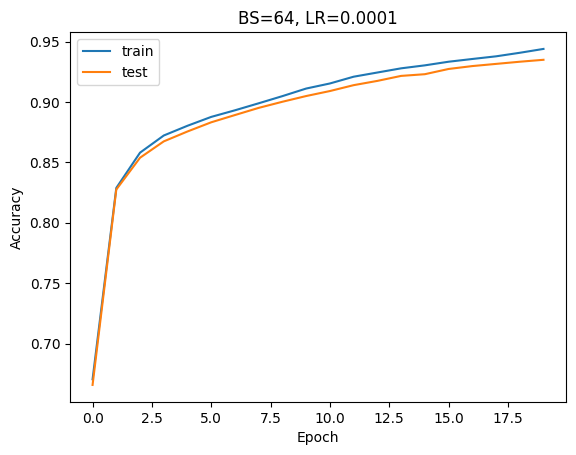

In [53]:
plt.plot(train_acc_log_1, label='train')
plt.plot(val_acc_log_1, label="test")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title("BS=64, LR=0.0001")
plt.legend()
plt.show()

In [36]:
cnn = CNN().to(Device)

train_loader = get_loader(X_train[:15000], y_train[:15000], 64)
val_loader = get_loader(X_train[15000:30000], y_train[15000:30000], 64)

Optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

train_log_2, train_acc_log_2, val_log_2, val_acc_log_2 = train(cnn,
                                                      Optimizer,
                                                      train_loader,
                                                      val_loader)

Epoch [1/20], Loss (train/test): 0.3227/0.3447, Acc (train/test): 0.9039/0.8977
Epoch [2/20], Loss (train/test): 0.2063/0.2317, Acc (train/test): 0.9375/0.9295
Epoch [3/20], Loss (train/test): 0.1344/0.1616, Acc (train/test): 0.9586/0.9499
Epoch [4/20], Loss (train/test): 0.0993/0.1293, Acc (train/test): 0.9695/0.9599
Epoch [5/20], Loss (train/test): 0.0765/0.1092, Acc (train/test): 0.9754/0.9667
Epoch [6/20], Loss (train/test): 0.0613/0.0976, Acc (train/test): 0.9809/0.9691
Epoch [7/20], Loss (train/test): 0.0497/0.0898, Acc (train/test): 0.9851/0.9721
Epoch [8/20], Loss (train/test): 0.0406/0.0843, Acc (train/test): 0.9877/0.9743
Epoch [9/20], Loss (train/test): 0.0334/0.0792, Acc (train/test): 0.9904/0.9765
Epoch [10/20], Loss (train/test): 0.0272/0.0785, Acc (train/test): 0.9915/0.9775
Epoch [11/20], Loss (train/test): 0.0263/0.0843, Acc (train/test): 0.9917/0.9754
Epoch [12/20], Loss (train/test): 0.0271/0.0948, Acc (train/test): 0.9901/0.9740
Epoch [13/20], Loss (train/test): 0.0

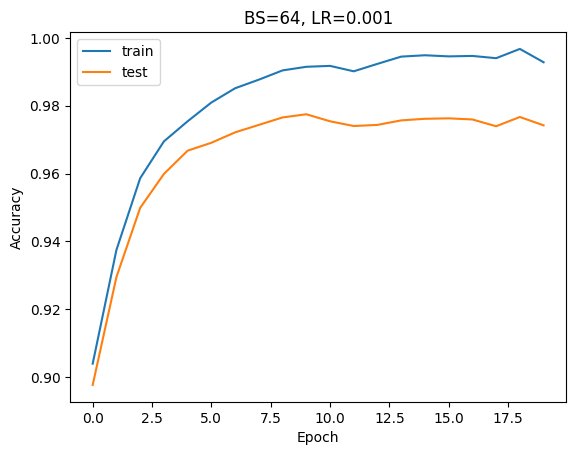

In [54]:
plt.plot(train_acc_log_2, label='train')
plt.plot(val_acc_log_2, label="test")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title("BS=64, LR=0.001")
plt.legend()
plt.show()

In [37]:
cnn = CNN().to(Device)

train_loader = get_loader(X_train[:15000], y_train[:15000], 64)
val_loader = get_loader(X_train[15000:30000], y_train[15000:30000], 64)

Optimizer = torch.optim.Adam(cnn.parameters(), lr=0.01)

train_log_3, train_acc_log_3, val_log_3, val_acc_log_3 = train(cnn,
                                                      Optimizer,
                                                      train_loader,
                                                      val_loader)

Epoch [1/20], Loss (train/test): 0.1073/0.1355, Acc (train/test): 0.9663/0.9587
Epoch [2/20], Loss (train/test): 0.0562/0.0893, Acc (train/test): 0.9819/0.9736
Epoch [3/20], Loss (train/test): 0.0755/0.1148, Acc (train/test): 0.9757/0.9679
Epoch [4/20], Loss (train/test): 0.0444/0.0931, Acc (train/test): 0.9865/0.9735
Epoch [5/20], Loss (train/test): 0.0353/0.0968, Acc (train/test): 0.9897/0.9754
Epoch [6/20], Loss (train/test): 0.0213/0.0854, Acc (train/test): 0.9931/0.9789
Epoch [7/20], Loss (train/test): 0.0629/0.1595, Acc (train/test): 0.9847/0.9695
Epoch [8/20], Loss (train/test): 0.0287/0.1137, Acc (train/test): 0.9910/0.9745
Epoch [9/20], Loss (train/test): 0.0215/0.1063, Acc (train/test): 0.9936/0.9797
Epoch [10/20], Loss (train/test): 0.0195/0.1059, Acc (train/test): 0.9940/0.9771
Epoch [11/20], Loss (train/test): 0.0409/0.1449, Acc (train/test): 0.9884/0.9727
Epoch [12/20], Loss (train/test): 0.0229/0.1321, Acc (train/test): 0.9939/0.9756
Epoch [13/20], Loss (train/test): 0.0

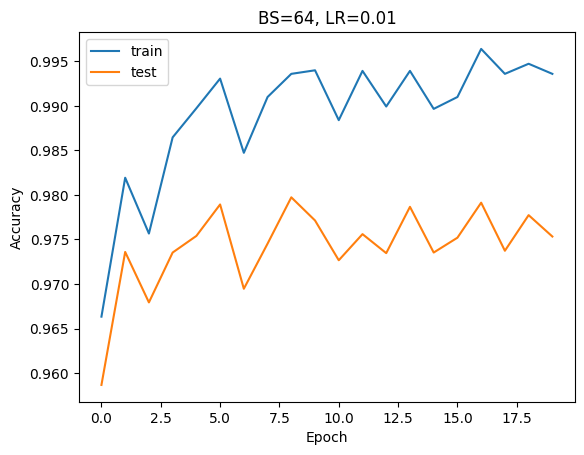

In [55]:
plt.plot(train_acc_log_3, label='train')
plt.plot(val_acc_log_3, label="test")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title("BS=64, LR=0.01")
plt.legend()
plt.show()

In [38]:
cnn = CNN().to(Device)

train_loader = get_loader(X_train[:15000], y_train[:15000], 256)
val_loader = get_loader(X_train[15000:30000], y_train[15000:30000], 256)

Optimizer = torch.optim.Adam(cnn.parameters(), lr=0.0001)

train_log_4, train_acc_log_4, val_log_4, val_acc_log_4 = train(cnn,
                                                      Optimizer,
                                                      train_loader,
                                                      val_loader)

Epoch [1/20], Loss (train/test): 2.2464/2.2477, Acc (train/test): 0.3735/0.3609
Epoch [2/20], Loss (train/test): 1.9912/1.9950, Acc (train/test): 0.5894/0.5856
Epoch [3/20], Loss (train/test): 1.3549/1.3574, Acc (train/test): 0.6912/0.6863
Epoch [4/20], Loss (train/test): 0.8603/0.8615, Acc (train/test): 0.7908/0.7907
Epoch [5/20], Loss (train/test): 0.6702/0.6727, Acc (train/test): 0.8185/0.8188
Epoch [6/20], Loss (train/test): 0.5837/0.5874, Acc (train/test): 0.8365/0.8339
Epoch [7/20], Loss (train/test): 0.5334/0.5382, Acc (train/test): 0.8468/0.8453
Epoch [8/20], Loss (train/test): 0.4987/0.5043, Acc (train/test): 0.8549/0.8530
Epoch [9/20], Loss (train/test): 0.4720/0.4785, Acc (train/test): 0.8631/0.8593
Epoch [10/20], Loss (train/test): 0.4503/0.4574, Acc (train/test): 0.8692/0.8633
Epoch [11/20], Loss (train/test): 0.4322/0.4399, Acc (train/test): 0.8739/0.8686
Epoch [12/20], Loss (train/test): 0.4167/0.4249, Acc (train/test): 0.8777/0.8733
Epoch [13/20], Loss (train/test): 0.4

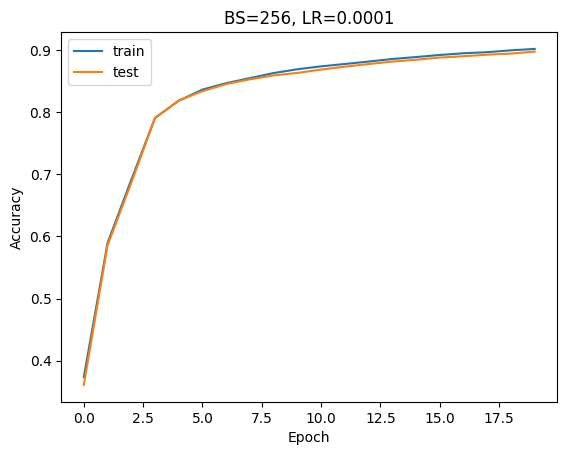

In [56]:
plt.plot(train_acc_log_4, label='train')
plt.plot(val_acc_log_4, label="test")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title("BS=256, LR=0.0001")
plt.legend()
plt.show()

In [39]:
cnn = CNN().to(Device)

train_loader = get_loader(X_train[:15000], y_train[:15000], 256)
val_loader = get_loader(X_train[15000:30000], y_train[15000:30000], 256)

Optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

train_log_5, train_acc_log_5, val_log_5, val_acc_log_5 = train(cnn,
                                                      Optimizer,
                                                      train_loader,
                                                      val_loader)

Epoch [1/20], Loss (train/test): 0.6567/0.6692, Acc (train/test): 0.7930/0.7938
Epoch [2/20], Loss (train/test): 0.4389/0.4514, Acc (train/test): 0.8668/0.8631
Epoch [3/20], Loss (train/test): 0.3444/0.3618, Acc (train/test): 0.8952/0.8914
Epoch [4/20], Loss (train/test): 0.2805/0.3015, Acc (train/test): 0.9152/0.9086
Epoch [5/20], Loss (train/test): 0.2320/0.2552, Acc (train/test): 0.9305/0.9221
Epoch [6/20], Loss (train/test): 0.2018/0.2264, Acc (train/test): 0.9376/0.9285
Epoch [7/20], Loss (train/test): 0.1810/0.2069, Acc (train/test): 0.9441/0.9341
Epoch [8/20], Loss (train/test): 0.1568/0.1849, Acc (train/test): 0.9516/0.9414
Epoch [9/20], Loss (train/test): 0.1405/0.1708, Acc (train/test): 0.9565/0.9463
Epoch [10/20], Loss (train/test): 0.1248/0.1577, Acc (train/test): 0.9603/0.9511
Epoch [11/20], Loss (train/test): 0.1123/0.1484, Acc (train/test): 0.9637/0.9541
Epoch [12/20], Loss (train/test): 0.1019/0.1405, Acc (train/test): 0.9670/0.9572
Epoch [13/20], Loss (train/test): 0.0

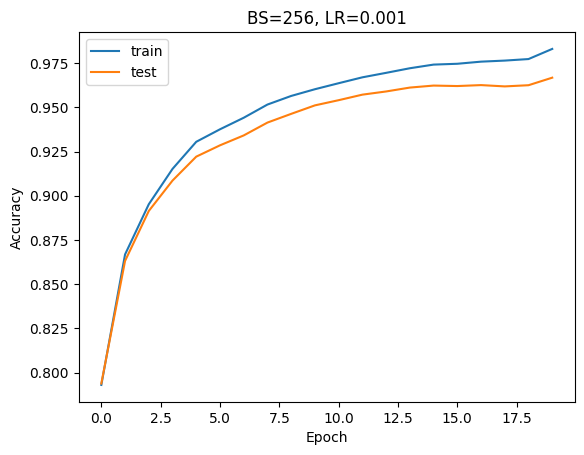

In [57]:
plt.plot(train_acc_log_5, label='train')
plt.plot(val_acc_log_5, label="test")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title("BS=256, LR=0.001")
plt.legend()
plt.show()

In [40]:
cnn = CNN().to(Device)

train_loader = get_loader(X_train[:15000], y_train[:15000], 256)
val_loader = get_loader(X_train[15000:30000], y_train[15000:30000], 256)

Optimizer = torch.optim.Adam(cnn.parameters(), lr=0.01)

train_log_6, train_acc_log_6, val_log_6, val_acc_log_6 = train(cnn,
                                                      Optimizer,
                                                      train_loader,
                                                      val_loader)

Epoch [1/20], Loss (train/test): 0.2303/0.2477, Acc (train/test): 0.9262/0.9237
Epoch [2/20], Loss (train/test): 0.1209/0.1497, Acc (train/test): 0.9615/0.9545
Epoch [3/20], Loss (train/test): 0.0684/0.1109, Acc (train/test): 0.9787/0.9659
Epoch [4/20], Loss (train/test): 0.0378/0.0881, Acc (train/test): 0.9886/0.9731
Epoch [5/20], Loss (train/test): 0.0382/0.0937, Acc (train/test): 0.9877/0.9731
Epoch [6/20], Loss (train/test): 0.0394/0.0983, Acc (train/test): 0.9873/0.9705
Epoch [7/20], Loss (train/test): 0.0366/0.0982, Acc (train/test): 0.9875/0.9715
Epoch [8/20], Loss (train/test): 0.0272/0.0929, Acc (train/test): 0.9913/0.9747
Epoch [9/20], Loss (train/test): 0.0203/0.0933, Acc (train/test): 0.9943/0.9747
Epoch [10/20], Loss (train/test): 0.0228/0.1127, Acc (train/test): 0.9920/0.9734
Epoch [11/20], Loss (train/test): 0.0429/0.1371, Acc (train/test): 0.9873/0.9693
Epoch [12/20], Loss (train/test): 0.0179/0.0943, Acc (train/test): 0.9943/0.9768
Epoch [13/20], Loss (train/test): 0.0

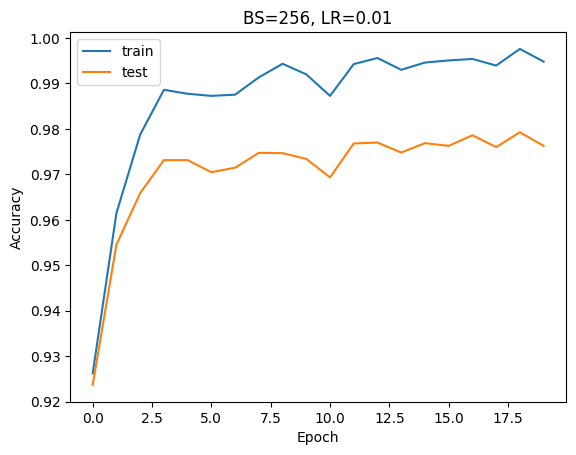

In [58]:
plt.plot(train_acc_log_6, label='train')
plt.plot(val_acc_log_6, label="test")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title("BS=256, LR=0.01")
plt.legend()
plt.show()

### Changing the architecture

Try to modify our architecture: increase the number of filters and to reduce the number of fully-connected layers.

Insert numbers in the brackets:
* LeNet-5 classic (6 and 16 convolutions):  training acc: (0.9786)  validation acc: (0.9939)
* Number of convolutions x 4 (24 и 64 convolutions):  training acc: (0.9765)  validation acc: (0.9619)
* Removing fully connected layer: the previous network with 1 FC layer: training acc: (0.9791)  validation acc: (0.9836)

In [61]:
class LeNetBased(nn.Module):
    def __init__(self, n_channels=N_CHANNELS, n_classes=N_CLASSES, k=1):
        super(LeNetBased, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=n_channels, out_channels=6, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1080, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Choose the learning rate, batch size and the architecture based on your experiments. Train a network on the full dataset and print accuracy on the full test set.

In [70]:
net = LeNetBased().to(Device)

Optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

train_log_, train_acc_log_, val_log_, val_acc_log_ = train(net,
                                                      Optimizer,
                                                      train_loader_full,
                                                      test_loader,
                                                      n_epochs=30)

Epoch [1/30], Loss (train/test): 0.1049/0.1071, Acc (train/test): 0.9678/0.9665
Epoch [2/30], Loss (train/test): 0.0596/0.0682, Acc (train/test): 0.9815/0.9786
Epoch [3/30], Loss (train/test): 0.0399/0.0519, Acc (train/test): 0.9875/0.9837
Epoch [4/30], Loss (train/test): 0.0421/0.0600, Acc (train/test): 0.9867/0.9810
Epoch [5/30], Loss (train/test): 0.0336/0.0551, Acc (train/test): 0.9893/0.9835
Epoch [6/30], Loss (train/test): 0.0223/0.0450, Acc (train/test): 0.9929/0.9867
Epoch [7/30], Loss (train/test): 0.0264/0.0558, Acc (train/test): 0.9918/0.9850
Epoch [8/30], Loss (train/test): 0.0265/0.0578, Acc (train/test): 0.9920/0.9844
Epoch [9/30], Loss (train/test): 0.0406/0.0843, Acc (train/test): 0.9885/0.9806
Epoch [10/30], Loss (train/test): 0.0239/0.0580, Acc (train/test): 0.9928/0.9850
Epoch [11/30], Loss (train/test): 0.0375/0.0856, Acc (train/test): 0.9893/0.9797
Epoch [12/30], Loss (train/test): 0.0220/0.0590, Acc (train/test): 0.9938/0.9871
Epoch [13/30], Loss (train/test): 0.0

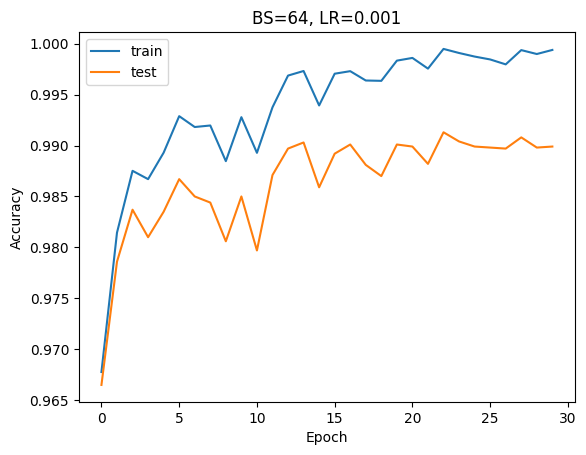

In [71]:
plt.plot(train_acc_log_, label='train')
plt.plot(val_acc_log_, label="test")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title("BS=64, LR=0.001")
plt.legend()
plt.show()

In [73]:
print(f"Best accuracy on full tets set: {val_acc_log_[np.argmax(val_acc_log_)]}")

Best accuracy on full tets set: 0.9913
